In [1]:
import os
import uproot
import numpy as np

def load_root_file(file_path, branches=None, print_branches=False):
    all_branches = {}
    with uproot.open(file_path) as file:
        tree = file["tree"]
        # Load all ROOT branches into array if not specified
        if branches is None:
            branches = tree.keys()
        # Option to print the branch names
        if print_branches:
            print("Branches:", tree.keys())
        # Each branch is added to the dictionary
        for branch in branches:
            try:
                all_branches[branch] = (tree[branch].array(library="np"))
            except uproot.KeyInFileError as e:
                print(f"KeyInFileError: {e}")
        # Number of events in file
        all_branches['event'] = tree.num_entries
    return all_branches

branches_list = [
    't5_innerRadius',
    't5_bridgeRadius',
    't5_outerRadius',
    't5_pt',
    't5_eta',
    't5_phi',
    't5_isFake',
    't5_t3_idx0',
    't5_t3_idx1',
    't5_pMatched',
    't5_sim_vxy',
    't5_sim_vz'
]

# Hit-dependent branches
suffixes = ['r', 'z', 'eta', 'phi', 'layer']
branches_list += [f't5_t3_{i}_{suffix}' for i in [0, 2, 4] for suffix in suffixes]

file_path = "1000_no_dnn_for_phi.root"
branches = load_root_file(file_path, branches_list)

In [2]:
z_max = np.max([np.max(event) for event in branches[f't5_t3_4_z']])
r_max = np.max([np.max(event) for event in branches[f't5_t3_4_r']])
eta_max = 2.5
phi_max = np.pi

print(f'Z max: {z_max}, R max: {r_max}, Eta max: {eta_max}')

Z max: 267.2349853515625, R max: 110.10993957519531, Eta max: 2.5


In [3]:
features_list = []
eta_list = [] # Used for DNN cut values

for event in range(branches['event']):
    # Determine the number of elements in this event
    num_elements = len(branches['t5_t3_idx0'][event])

    for i in range(num_elements):
        features_iter = []
        eta_iter = []
        
        idx0 = branches['t5_t3_idx0'][event][i]
        idx1 = branches['t5_t3_idx1'][event][i]

        # Collect features using idx0
        features_iter.extend([
            np.abs(branches['t5_t3_0_eta'][event][idx0]) / eta_max,
            np.abs(branches['t5_t3_0_phi'][event][idx0]) / phi_max,
            np.abs(branches['t5_t3_0_z'][event][idx0]) / z_max,
            branches['t5_t3_0_r'][event][idx0] / r_max,
            np.abs(branches['t5_t3_2_eta'][event][idx0]) - np.abs(branches['t5_t3_0_eta'][event][idx0]),
            (np.abs(branches['t5_t3_2_phi'][event][idx0]) - np.abs(branches['t5_t3_0_phi'][event][idx0])) / phi_max,
            (np.abs(branches['t5_t3_2_z'][event][idx0]) - np.abs(branches['t5_t3_0_z'][event][idx0])) / z_max,
            (branches['t5_t3_2_r'][event][idx0] - branches['t5_t3_0_r'][event][idx0]) / r_max,
            np.abs(branches['t5_t3_4_eta'][event][idx0]) - np.abs(branches['t5_t3_2_eta'][event][idx0]),
            (np.abs(branches['t5_t3_4_phi'][event][idx0]) - np.abs(branches['t5_t3_2_phi'][event][idx0])) / phi_max,
            (np.abs(branches['t5_t3_4_z'][event][idx0]) - np.abs(branches['t5_t3_2_z'][event][idx0])) / z_max,
            (branches['t5_t3_4_r'][event][idx0] - branches['t5_t3_2_r'][event][idx0]) / r_max,
        ])
        
        # Collect features using idx1
        features_iter.extend([
            np.abs(branches['t5_t3_2_eta'][event][idx1]) - np.abs(branches['t5_t3_4_eta'][event][idx0]),
            (np.abs(branches['t5_t3_2_phi'][event][idx1]) - np.abs(branches['t5_t3_4_phi'][event][idx0])) / phi_max,
            (np.abs(branches['t5_t3_2_z'][event][idx1]) - np.abs(branches['t5_t3_4_z'][event][idx0])) / z_max,
            (branches['t5_t3_2_r'][event][idx1] - branches['t5_t3_4_r'][event][idx0]) / r_max,
            np.abs(branches['t5_t3_4_eta'][event][idx1]) - np.abs(branches['t5_t3_2_eta'][event][idx1]),
            (np.abs(branches['t5_t3_4_phi'][event][idx1]) - np.abs(branches['t5_t3_2_phi'][event][idx1])) / phi_max,
            (np.abs(branches['t5_t3_4_z'][event][idx1]) - np.abs(branches['t5_t3_2_z'][event][idx1])) / z_max,
            (branches['t5_t3_4_r'][event][idx1] - branches['t5_t3_2_r'][event][idx1]) / r_max,
        ])
        
        # Add remaining features
        features_iter.extend([
            np.log10(branches['t5_innerRadius'][event][i]),
            np.log10(branches['t5_bridgeRadius'][event][i]),
            np.log10(branches['t5_outerRadius'][event][i]),
        ])

        # Use the abs eta value of first hit to select cut thresholds
        eta_iter.extend([np.abs(branches['t5_t3_0_eta'][event][idx0])])
        
        # Append the feature vector to the list
        features_list.append(features_iter)
        eta_list.append(eta_iter)

# Convert the list of features to a NumPy array
features = np.array(features_list).T
eta_list = np.array(eta_list).T

In [4]:
import torch

# Stack features along a new axis to form a single array suitable for NN input
input_features_numpy = np.stack(features, axis=-1)

# Identify rows with NaN or Inf values
mask = ~np.isnan(input_features_numpy) & ~np.isinf(input_features_numpy)

# Apply mask across all columns: retain a row only if all its entries are neither NaN nor Inf
filtered_input_features_numpy = input_features_numpy[np.all(mask, axis=1)]
t5_isFake_filtered = np.concatenate(branches['t5_isFake'])[np.all(mask, axis=1)]

# Convert to PyTorch tensor when ready to use with NN
input_features_tensor = torch.tensor(filtered_input_features_numpy, dtype=torch.float32)

In [5]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create labels tensor
labels_tensor = 1 - torch.tensor(t5_isFake_filtered, dtype=torch.float32)

# Set initial downsample fraction
initial_downsample_fraction = 1.0  # Adjust this value as needed

class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features_numpy.shape[1], 32)
        self.layer2 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x

class WeightedBCELoss(nn.Module):
    def __init__(self):
        super(WeightedBCELoss, self).__init__()
        
    def forward(self, outputs, targets, weights):
        eps = 1e-7
        losses = -(weights * (targets * torch.log(outputs + eps) + 
                            (1 - targets) * torch.log(1 - outputs + eps)))
        return losses.mean()

def calculate_sample_weights(t5_sim_vxy, weight_factor=4.0):
    """
    Calculate sample weights giving higher importance to displaced t5's
    
    Args:
        t5_sim_vxy: Array of t5 simulation values
        weight_factor: How much more weight to give to displaced samples
    
    Returns:
        Tensor of sample weights
    """
    weights = torch.ones(len(t5_sim_vxy))
    displaced_mask = t5_sim_vxy > 0.1
    weights[displaced_mask] = weight_factor
    return weights

# Print initial dataset size
print(f"Initial dataset size: {len(labels_tensor)}")

# Calculate sample weights
sample_weights = calculate_sample_weights(torch.tensor(np.concatenate(branches['t5_sim_vxy'])))

# Remove rows with NaN and update weights accordingly
nan_mask = torch.isnan(input_features_tensor).any(dim=1) | torch.isnan(labels_tensor)
filtered_inputs = input_features_tensor[~nan_mask]
filtered_labels = labels_tensor[~nan_mask]
filtered_weights = sample_weights[~nan_mask]

# Initial downsampling of entire dataset
if initial_downsample_fraction < 1.0:
    total_samples = len(filtered_labels)
    samples_to_keep = int(total_samples * initial_downsample_fraction)
    indices = torch.randperm(total_samples)[:samples_to_keep]
    filtered_inputs = filtered_inputs[indices]
    filtered_labels = filtered_labels[indices]
    filtered_weights = filtered_weights[indices]

print(f"Dataset size after initial {initial_downsample_fraction*100}% downsampling: {len(filtered_labels)}")

# Count samples in each class after initial downsampling
class_counts = torch.bincount(filtered_labels.int())
print(f"Class distribution after initial downsampling - Class 0: {class_counts[0]}, Class 1: {class_counts[1]}")

# Balance classes while maintaining weights
minority_class = 0 if class_counts[0] < class_counts[1] else 1
minority_indices = (filtered_labels == minority_class).nonzero(as_tuple=True)[0]
majority_indices = (filtered_labels == (1 - minority_class)).nonzero(as_tuple=True)[0]
downsampled_majority_indices = majority_indices[torch.randperm(len(majority_indices))[:len(minority_indices)]]
balanced_indices = torch.cat((minority_indices, downsampled_majority_indices))

# Create balanced dataset with weights
balanced_inputs = filtered_inputs[balanced_indices]
balanced_labels = filtered_labels[balanced_indices]
balanced_weights = filtered_weights[balanced_indices]

# Verify balanced distribution
balanced_counts = torch.bincount(balanced_labels.int())
print(f"Final class distribution after balancing - Class 0: {balanced_counts[0]}, Class 1: {balanced_counts[1]}")

# Create dataset with weights
dataset = TensorDataset(balanced_inputs, balanced_labels, balanced_weights)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=10, pin_memory=True)

# Initialize model and optimizer
model = MyNeuralNetwork().to(device)
loss_function = WeightedBCELoss()
optimizer = Adam(model.parameters(), lr=0.0025)

def evaluate_model(loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, targets, weights in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5
            total += targets.size(0)
            correct += (predicted == targets.bool()).sum().item()
    model.train()
    return 100 * correct / total

# Training loop
num_epochs = 150
loss_log = []

for epoch in range(num_epochs):
    for inputs, targets, weights in train_loader:
        inputs, targets, weights = inputs.to(device), targets.to(device), weights.to(device)
    
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs.squeeze(), targets, weights)
        
        loss_log.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_accuracy = evaluate_model(train_loader)
    test_accuracy = evaluate_model(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

Using device: cuda
Initial dataset size: 10921577
Dataset size after initial 100.0% downsampling: 10921577
Class distribution after initial downsampling - Class 0: 2985946, Class 1: 7935631
Final class distribution after balancing - Class 0: 2985946, Class 1: 2985946
Epoch [1/150], Loss: 0.4886, Train Acc: 82.41%, Test Acc: 82.36%
Epoch [2/150], Loss: 0.6367, Train Acc: 81.77%, Test Acc: 81.74%
Epoch [3/150], Loss: 0.3873, Train Acc: 83.34%, Test Acc: 83.26%
Epoch [4/150], Loss: 0.4289, Train Acc: 83.46%, Test Acc: 83.39%
Epoch [5/150], Loss: 0.4747, Train Acc: 83.05%, Test Acc: 82.99%
Epoch [6/150], Loss: 0.4781, Train Acc: 83.51%, Test Acc: 83.43%
Epoch [7/150], Loss: 0.4483, Train Acc: 83.94%, Test Acc: 83.87%
Epoch [8/150], Loss: 0.4133, Train Acc: 84.22%, Test Acc: 84.12%
Epoch [9/150], Loss: 0.3683, Train Acc: 83.48%, Test Acc: 83.42%
Epoch [10/150], Loss: 0.3827, Train Acc: 83.87%, Test Acc: 83.75%
Epoch [11/150], Loss: 0.3543, Train Acc: 84.20%, Test Acc: 84.07%
Epoch [12/150],

In [6]:
torch.save(model.state_dict(), "model.pth")

In [7]:
from sklearn.metrics import accuracy_score

# Convert tensors to numpy for simplicity in permutation
input_features_np = input_features_tensor.numpy()
labels_np = labels_tensor.numpy()

def model_accuracy(features, labels, model):
    model.eval()  # Set the model to evaluation mode
    inputs = features.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()  # Update threshold as necessary
        accuracy = (predicted == labels).float().mean().item()
    return accuracy

# Use the original input_features_tensor and labels_tensor directly
baseline_accuracy = model_accuracy(input_features_tensor, labels_tensor, model)
print(f"Baseline accuracy: {baseline_accuracy}")

# Initialize an array to store feature importances
feature_importances = np.zeros(input_features_tensor.shape[1])

# Permute each feature and calculate the drop in accuracy
for i in range(input_features_tensor.shape[1]):
    permuted_features = input_features_tensor.clone()
    permuted_features[:, i] = permuted_features[torch.randperm(permuted_features.size(0)), i]  # Permute feature

    permuted_accuracy = model_accuracy(permuted_features, labels_tensor, model)
    feature_importances[i] = baseline_accuracy - permuted_accuracy

# Ranking features by importance
important_features_indices = np.argsort(feature_importances)[::-1]  # Indices of features in descending importance
important_features_scores = np.sort(feature_importances)[::-1]  # Importance scores in descending order

print("Feature importances:")
for idx, score in zip(important_features_indices, important_features_scores):
    print(f"Feature {idx} importance: {score:.4f}")

Baseline accuracy: 0.8729903697967529
Feature importances:
Feature 21 importance: 0.3862
Feature 20 importance: 0.1981
Feature 22 importance: 0.1758
Feature 12 importance: 0.1662
Feature 0 importance: 0.1173
Feature 5 importance: 0.1124
Feature 8 importance: 0.0744
Feature 16 importance: 0.0733
Feature 2 importance: 0.0675
Feature 13 importance: 0.0632
Feature 17 importance: 0.0589
Feature 4 importance: 0.0350
Feature 10 importance: 0.0212
Feature 3 importance: 0.0171
Feature 14 importance: 0.0155
Feature 6 importance: 0.0132
Feature 1 importance: 0.0103
Feature 18 importance: 0.0100
Feature 9 importance: 0.0092
Feature 7 importance: 0.0079
Feature 15 importance: 0.0074
Feature 19 importance: 0.0035
Feature 11 importance: 0.0023


/tmp/ipykernel_1579316/52354147.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


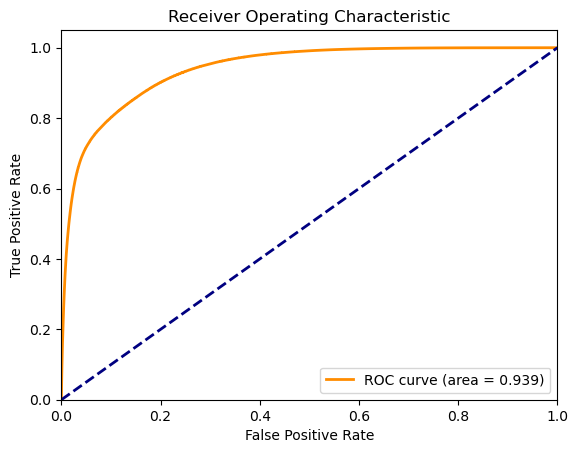

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def model_outputs(features, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        inputs = torch.tensor(features, dtype=torch.float32).to(device)
        outputs = model(inputs).squeeze().cpu().numpy()
    return outputs

# Calculate model outputs
probabilities = model_outputs(filtered_inputs, model)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(filtered_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

/tmp/ipykernel_1579316/52354147.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


Prediction scores for displaced tracks (t5_sim_vxy > 0.1):
Mean score: 0.8244
Median score: 0.9473


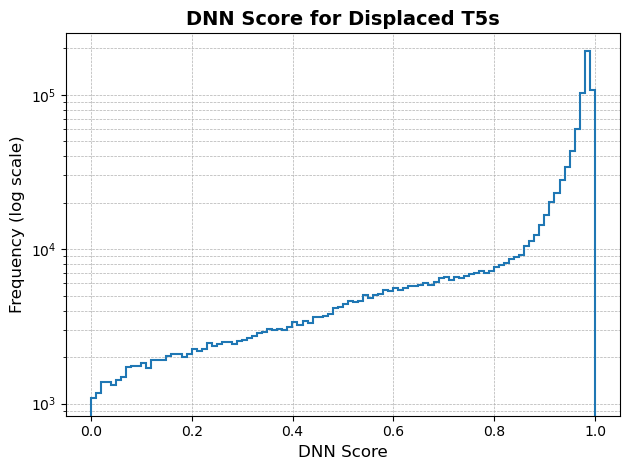

In [23]:
# Get model predictions
probabilities = model_outputs(filtered_inputs, model)

# Get displaced track mask
displaced_mask = np.concatenate(branches['t5_sim_vxy'])[~nan_mask] > 0.1

# Calculate statistics for displaced tracks
displaced_predictions = probabilities[displaced_mask]
mean_score = np.mean(displaced_predictions)
median_score = np.median(displaced_predictions)

print(f"Prediction scores for displaced tracks (t5_sim_vxy > 0.1):")
print(f"Mean score: {mean_score:.4f}")
print(f"Median score: {median_score:.4f}")

plt.hist(displaced_predictions, bins=100, histtype='step', linewidth=1.5)  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score for Displaced T5s", fontsize=14, weight='bold')

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [10]:
def print_formatted_weights_biases(weights, biases, layer_name):
    # Print biases
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_{layer_name}[{len(biases)}] = {{")
    print(", ".join(f"{b:.7f}f" for b in biases) + " };")
    print()

    # Print weights
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_{layer_name}[{len(weights[0])}][{len(weights)}] = {{")
    for row in weights.T:
        formatted_row = ", ".join(f"{w:.7f}f" for w in row)
        print(f"{{ {formatted_row} }},")
    print("};")
    print()

def print_model_weights_biases(model):
    # Make sure the model is in evaluation mode
    model.eval()

    # Iterate through all named modules in the model
    for name, module in model.named_modules():
        # Check if the module is a linear layer
        if isinstance(module, nn.Linear):
            # Get weights and biases
            weights = module.weight.data.cpu().numpy()
            biases = module.bias.data.cpu().numpy()

            # Print formatted weights and biases
            print_formatted_weights_biases(weights, biases, name.replace('.', '_'))

print_model_weights_biases(model)


ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_layer1[32] = {
-1.7128716f, 0.1342516f, -1.4310330f, 0.2064559f, 3.1270707f, 1.2044203f, -0.4247369f, 0.9003102f, 0.0465960f, 0.0128122f, 1.6568773f, 0.1776162f, 2.0805979f, -0.0997964f, -0.9894860f, -0.0648111f, -0.0193663f, -0.0596841f, -2.0598757f, 1.4699619f, -3.9257181f, -0.0218257f, 0.1042878f, 0.0027751f, -0.3767176f, 0.0642788f, 0.3004227f, 1.1816521f, -0.1448327f, -2.7598374f, 0.8325039f, -1.5783384f };

ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_layer1[23][32] = {
{ 1.0470641f, -0.1197168f, 1.8577816f, -0.0060186f, -0.7541588f, 1.1680204f, 0.6370878f, -1.4548999f, -0.0383963f, -0.1543131f, -0.3489025f, -0.0702869f, 2.8539977f, -0.0969742f, 2.2843301f, -0.2135435f, -0.0066958f, -0.0008692f, 1.3951476f, -0.1181870f, -0.3345473f, -0.1450863f, -0.1452127f, -0.0842553f, 0.1165620f, -0.1126658f, 1.1788466f, 0.7880565f, 0.1118686f, 0.4665366f, -0.5639495f, 1.3219374f },
{ -0.0046852f, 0.1385111f, -0.0405697f, -0.0068917f, 0.0057400f, 

In [11]:
# Ensure input_features_tensor is moved to the appropriate device
input_features_tensor = input_features_tensor.to(device)

# Make predictions
with torch.no_grad():
    model.eval()
    outputs = model(input_features_tensor)
    predictions = outputs.squeeze().cpu().numpy()

full_tracks = (np.concatenate(branches['t5_isFake']) == 0) * (np.concatenate(branches['t5_pMatched']) > 0.95)

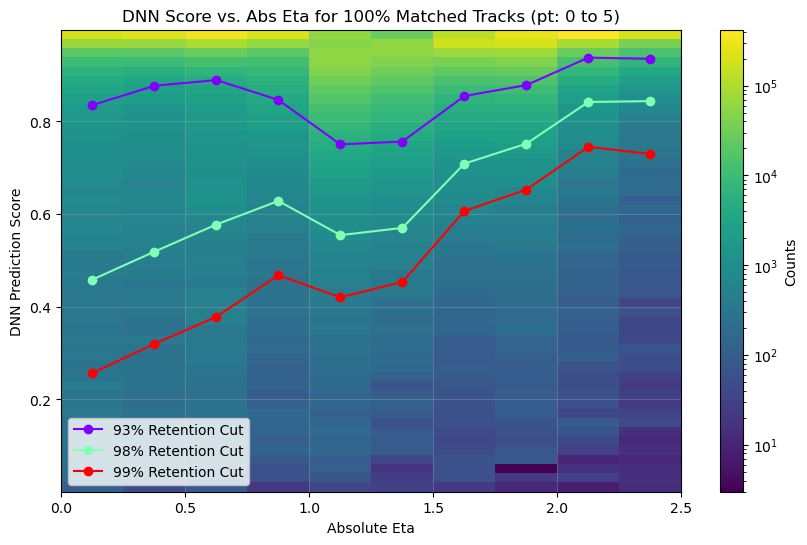


pt: 0 to 5
93% Retention Cut: {0.8353, 0.877, 0.8893, 0.8464, 0.7505, 0.7567, 0.8549, 0.8785, 0.9379, 0.9352} Mean: 0.8562
98% Retention Cut: {0.4586, 0.519, 0.5776, 0.6284, 0.5546, 0.5703, 0.7089, 0.7521, 0.8421, 0.8439} Mean: 0.6455
99% Retention Cut: {0.257, 0.3199, 0.3783, 0.4683, 0.4203, 0.4537, 0.6066, 0.6528, 0.7453, 0.7296} Mean: 0.5032


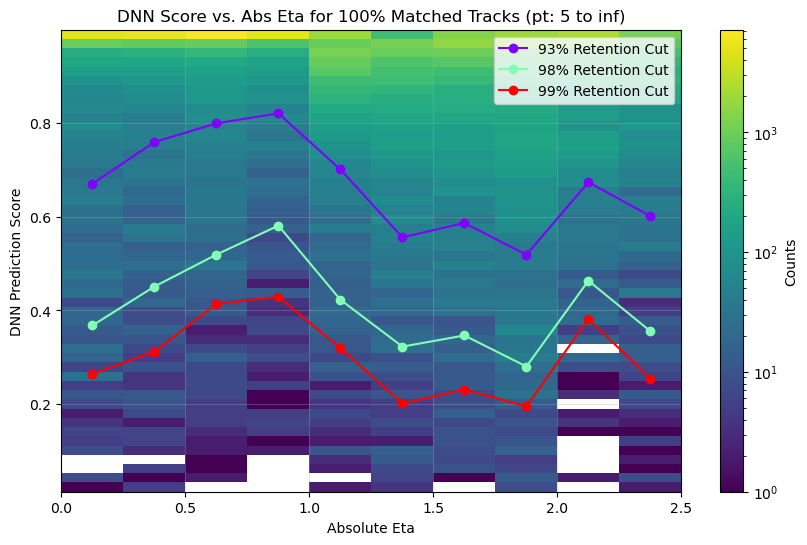


pt: 5 to inf
93% Retention Cut: {0.6703, 0.7594, 0.7993, 0.8206, 0.7008, 0.556, 0.5866, 0.5189, 0.6735, 0.6016} Mean: 0.6687
98% Retention Cut: {0.3678, 0.4509, 0.5192, 0.581, 0.4228, 0.3227, 0.3465, 0.2802, 0.4634, 0.3555} Mean: 0.411
99% Retention Cut: {0.2645, 0.3119, 0.4138, 0.4293, 0.3194, 0.2015, 0.231, 0.195, 0.3819, 0.2544} Mean: 0.3003


In [20]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

def plot_for_pt_bin(pt_min, pt_max, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
    """
    Calculate and plot cut values for specified percentiles in a given pt bin
    
    Parameters:
    -----------
    pt_min : float
        Minimum pt value for the bin
    pt_max : float
        Maximum pt value for the bin
    percentiles : list
        List of percentiles to calculate (e.g., [92.5, 96.7, 99])
    eta_bin_edges : array
        Edges of the eta bins
    eta_list : list
        List of eta values
    predictions : array
        Array of DNN predictions
    full_tracks : array
        Boolean array for track selection
    branches : dict
        Dictionary containing branch data
    """
    # Filter data based on pt bin
    abs_eta = eta_list[0][full_tracks & (np.concatenate(branches['t5_pt']) > pt_min) & 
                         (np.concatenate(branches['t5_pt']) <= pt_max)]
    predictions_filtered = predictions[full_tracks & (np.concatenate(branches['t5_pt']) > pt_min) & 
                                    (np.concatenate(branches['t5_pt']) <= pt_max)]
    
    # Dictionary to store cut values for different percentiles
    cut_values = {p: [] for p in percentiles}

    # Loop through each eta bin
    for i in range(len(eta_bin_edges) - 1):
        # Get indices of tracks within the current eta bin
        bin_indices = (abs_eta >= eta_bin_edges[i]) & (abs_eta < eta_bin_edges[i + 1])
        
        # Get the corresponding DNN prediction scores
        bin_predictions = predictions_filtered[bin_indices]
        
        # Calculate the percentile cut values for the current bin
        for percentile in percentiles:
            cut_value = np.percentile(bin_predictions, 100 - percentile)  # Convert retention to percentile
            cut_values[percentile].append(cut_value)

    # Plot 2D histogram
    plt.figure(figsize=(10, 6))
    plt.hist2d(abs_eta, predictions_filtered, bins=[eta_bin_edges, 50], norm=LogNorm())
    plt.colorbar(label='Counts')
    plt.xlabel("Absolute Eta")
    plt.ylabel("DNN Prediction Score")
    plt.title(f"DNN Score vs. Abs Eta for 100% Matched Tracks (pt: {pt_min} to {pt_max})")

    # Plot the cut values with different colors
    cut_x = eta_bin_edges[:-1] + (eta_bin_edges[1] - eta_bin_edges[0]) / 2  # Mid-points of the bins
    colors = plt.cm.rainbow(np.linspace(0, 1, len(percentiles)))  # Generate distinct colors
    
    for percentile, color in zip(percentiles, colors):
        plt.plot(cut_x, cut_values[percentile], '-', color=color, marker='o', 
                label=f'{percentile}% Retention Cut')
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print the cut values
    print(f"\npt: {pt_min} to {pt_max}")
    for percentile in percentiles:
        values = cut_values[percentile]
        print(f"{percentile}% Retention Cut:", 
              '{' + ', '.join(str(x) for x in np.round(values, 4)) + '}',
              "Mean:", np.round(np.mean(values), 4))

# Example usage:
def analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
    """
    Analyze and plot for multiple pt bins and percentiles
    
    Parameters:
    -----------
    pt_bins : list
        List of pt bin edges
    percentiles : list
        List of percentiles to calculate
    Other parameters same as plot_for_pt_bin function
    """
    for i in range(len(pt_bins) - 1):
        plot_for_pt_bin(pt_bins[i], pt_bins[i + 1], percentiles, eta_bin_edges, 
                       eta_list, predictions, full_tracks, branches)

# Example call:
percentiles = [93, 98, 99]
pt_bins = [0, 5, np.inf]
eta_bin_edges = np.arange(0, 2.75, 0.25)
analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches)